<a href="https://colab.research.google.com/github/kerndre/CCU-Forcasting/blob/main/3_Model/model_advanced_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
---
#Setup


## Imports

In [33]:
# Import necessary libraries from Google Colab
from google.colab import drive
from google.colab import userdata
import os  # Provides a way of using operating system dependent functionality

# Libraries for handling data formats and compression
import json  # Library for parsing JSON (JavaScript Object Notation) data

# Libraries for data manipulation and numerical operations
import numpy as np  # Library for numerical operations
import pandas as pd  # Library for data manipulation and analysis
from functools import reduce  # Higher-order function for functional programming
import random  # Library for generating random numbers

# Library for plotting graphs
import matplotlib.pyplot as plt

# Libraries for machine learning models and data preprocessing
from sklearn.preprocessing import StandardScaler  # Standardize features by removing the mean and scaling to unit variance
from xgboost import XGBRegressor  # XGBoost regressor
from lightgbm import LGBMRegressor  # LightGBM regressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score  # Tools for splitting datasets, time series split, parameter tuning, and cross-validation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score  # Performance metrics

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

# Set a fixed seed for reproducibility
random.seed(42)


## Connecting to Drive

In [34]:
# data path
data_path = '/content/drive/MyDrive/'

In [35]:
# Flushes the mounts, ensuring that all changes are written and the drive is safely unmounted
drive.flush_and_unmount()

# Mount the Google Drive to the specified path
drive.mount('/content/drive')

# Change the current working directory to the specified data path
os.chdir(data_path)

Mounted at /content/drive


## Functions

In [36]:
# Function to categorize the time of day based on the hour
def categorize_daytime(hour):
    # Check if the hour falls between 0 and 3 (inclusive) and return 'nachts'
    if 0 <= hour < 3:
        return 'nachts'
    # Check if the hour falls between 3 and 6 (inclusive) and return 'frühmorgens'
    elif 3 <= hour < 6:
        return 'frühmorgens'
    # Check if the hour falls between 6 and 9 (inclusive) and return 'morgens'
    elif 6 <= hour < 9:
        return 'morgens'
    # Check if the hour falls between 9 and 12 (inclusive) and return 'vormittags'
    elif 9 <= hour < 12:
        return 'vormittags'
    # Check if the hour falls between 12 and 15 (inclusive) and return 'nachmittags'
    elif 12 <= hour < 15:
        return 'nachmittags'
    # Check if the hour falls between 15 and 18 (inclusive) and return 'spätnachmittags'
    elif 15 <= hour < 18:
        return 'spätnachmittags'
    # Check if the hour falls between 18 and 21 (inclusive) and return 'abends'
    elif 18 <= hour < 21:
        return 'abends'
    # For any other hour (21 to 24), return 'spätabends'
    else:
        return 'spätabends'


In [37]:
# Function to create a DataFrame for model evaluation metrics
def create_evaluation_df(model_name, target, features, mse, mae, r2, explained_variance):
    # Create a dictionary with the evaluation metrics
    data = {
        'modelname': [model_name],             # Model name
        'target': [target],                    # Target variable
        'features': [features],                # List of features used
        'mse': [mse],                          # Mean Squared Error
        'mae': [mae],                          # Mean Absolute Error
        'r2': [r2],                            # R-squared value
        'explained_variance': [explained_variance]  # Explained Variance Score
    }

    # Convert the dictionary to a pandas DataFrame
    evaluation_df = pd.DataFrame(data)
    # Return the DataFrame
    return evaluation_df


---
---
# **Models**


The models used to analyze the data are **XGBoost Regressor** and **LightGBM Regressor**.

XGBoost and LightGBM are popular machine learning algorithms used for various predictive modeling tasks, including time series forecasting. Here are several reasons why these algorithms are suitable for time series data:

1. Handling Non-linearity:
Both XGBoost and LightGBM are gradient boosting algorithms that can model complex, non-linear relationships in the data. Time series data often exhibit non-linear patterns, such as seasonal trends, that simple linear models cannot capture effectively.

2. Feature Engineering:
These algorithms allow for extensive feature engineering, which is crucial in time series forecasting. By creating lag features, rolling statistics, and other time-based features, these models can leverage historical data effectively to make accurate predictions.

3. Speed and Efficiency:
LightGBM, in particular, is known for its efficiency and speed. It can handle large datasets with high dimensionality and complex interactions quickly, making it suitable for time series datasets that often contain numerous observations.

4. Regularization Techniques:
Both algorithms include built-in regularization techniques to prevent overfitting. This is particularly important in time series forecasting, where overfitting to historical data can lead to poor generalization on future data.

5. Ensemble Learning:
As ensemble methods, XGBoost and LightGBM combine the predictions of multiple weak learners (usually decision trees) to produce a more accurate and robust model. This ensemble approach can improve the predictive performance compared to single models.

6. Handling High Dimensional Data:
Time series data can become high-dimensional when including multiple features, such as lag values, moving averages, and other derived features. XGBoost and LightGBM are designed to handle high-dimensional data efficiently.

---
## Loading

In [38]:
# Set the loading version number
LOADING_VERSIONSNUMMER = 'v1.1'

# Retrieve the path to the project data using userdata
LOADING_PATH = userdata.get('ts_project_data_path')

# Define the name of the DataFrame file to be loaded
LOADING_DF_NAME = f'df_ts_ccu_{LOADING_VERSIONSNUMMER}'

# Define the name of the JSON file that contains the data types of the DataFrame
LOADING_DTYPES_DF_NAME = 'dtypes_' + LOADING_DF_NAME


In [39]:
# Load the dtypes (data types) from a JSON file

# Construct the full path to the JSON file containing the dtypes
dtypes_file_path = LOADING_PATH + '/' + LOADING_DTYPES_DF_NAME + '.json'

# Open the JSON file in read mode
with open(dtypes_file_path, 'r') as f:
    # Load the JSON content into a dictionary
    dtypes = json.load(f)


In [40]:
# Load the DataFrame from a CSV file
df_sl = pd.read_csv(
    LOADING_PATH + '/' + LOADING_DF_NAME + '.csv',  # Construct the full path to the CSV file
    dtype=dtypes,                                  # Specify the data types for each column
    parse_dates=['timestamp']                      # Tell pandas to parse the 'timestamp' column as dates
)


---


In [41]:
# shape of df
df_sl.shape

(5270376, 4)

In [42]:
# head of df
df_sl.head().style

,timestamp,abs_ended_sessions,mean_duration_end,concurrent_sessions
0,2024-03-01 00:00:12,0,0,603
1,2024-03-01 00:00:13,0,0,603
2,2024-03-01 00:00:14,0,0,603
3,2024-03-01 00:00:15,0,0,603
4,2024-03-01 00:00:16,0,0,603


In [43]:
# first and last date
df_sl.index.min(), df_sl.index.max()

(0, 5270375)

In [44]:
df_sl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5270376 entries, 0 to 5270375
Data columns (total 4 columns):
 #   Column               Dtype         
---  ------               -----         
 0   timestamp            datetime64[ns]
 1   abs_ended_sessions   int64         
 2   mean_duration_end    object        
 3   concurrent_sessions  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 160.8+ MB


In [45]:
# checking nan values
df_sl.isna().sum()

timestamp              0
abs_ended_sessions     0
mean_duration_end      0
concurrent_sessions    0
dtype: int64

---
## Feature Engineering

In parallel to the hypothesis of the baseline model that, due to their repetitive pattern, concurrent sessions can be predicted using the previous week's values, the models test a similar approach. They also incorporate the temporal component by looking at features that arise from the dissected timestamp to identify recurring patterns in the minute, hour, day and week structures.

In [46]:
# copy df_sl
df_ts = df_sl.copy()

### Split timestamp into several time features


In [47]:
# Extract and categorize the year from the timestamp column
df_ts['year'] = pd.Categorical(df_ts.timestamp.dt.year, ordered=True)

# Extract and categorize the month from the timestamp column
df_ts['month'] = pd.Categorical(df_ts.timestamp.dt.month, ordered=True)

# Extract and categorize the week of the year from the timestamp column
df_ts['week'] = pd.Categorical(df_ts['timestamp'].dt.isocalendar().week, ordered=True)

# Extract and categorize the hour from the timestamp column
df_ts['hour'] = pd.Categorical(df_ts.timestamp.dt.hour, ordered=True)

# Extract and categorize the minute from the timestamp column
df_ts['minute'] = pd.Categorical(df_ts.timestamp.dt.minute, ordered=True)

# Extract and categorize the second from the timestamp column
df_ts['second'] = pd.Categorical(df_ts.timestamp.dt.second, ordered=True)

In [48]:
# Convert the day of the week to a categorical variable, with Monday as day 1 and the rest of the week ordered accordingly
df_ts['day_week'] = pd.Categorical(
    df_ts.timestamp.dt.weekday + 1,  # Get the weekday (Monday=0, ..., Sunday=6) and add 1 to make Monday=1, ..., Sunday=7
    categories=[1, 2, 3, 4, 5, 6, 7],  # Explicit category order for days of the week
    ordered=True  # Ensure the categories are treated as an ordered categorical variable
)

In [49]:
# create feature day of the month based on time stamp
df_ts['day_month'] = pd.Categorical(df_ts.timestamp.dt.weekday, ordered=True)

###### creating an order for day names, month names and daytimes


In [50]:
# List of daytimes in German
daytimes = ['nachts', 'frühmorgens', 'morgens', 'vormittags', 'nachmittags', 'spätnachmittags', 'abends', 'spätabends']

# Create a mapping from daytime names to numeric values (e.g., 'nachts' -> 1, 'frühmorgens' -> 2, etc.)
daytime_mapping = {name: i + 1 for i, name in enumerate(daytimes)}

# Apply the categorize_daytime function to the hour extracted from the timestamp and create a categorical variable
df_ts['daytime_name'] = pd.Categorical(
    df_ts['timestamp'].dt.hour.apply(categorize_daytime),  # Categorize the hour of the day
    categories=daytimes,  # Use the predefined order of daytimes
    ordered=True  # Ensure the categories are treated as an ordered categorical variable
)

# Create the 'daytime' feature with numeric values using the daytime_mapping dictionary
df_ts['daytime'] = df_ts['daytime_name'].map(daytime_mapping)  # Map categorical daytime names to their numeric values

In [51]:
# drop column
df_ts.drop(columns=['daytime_name'], inplace=True)

### Lagged Values

In [52]:
# set timestamp as index
df_ts.set_index('timestamp', inplace=True)

In [53]:
# Shift the 'concurrent_sessions' column by 7 days to create a new column 'concurrent_sessions_7D'
# This represents the number of concurrent sessions exactly 7 days prior to the current timestamp
df_ts['concurrent_sessions_7D'] = df_ts.concurrent_sessions.shift(7, freq='D')

In [54]:
# drop NAs which that arose when creating the lagged values
# Means that the first week of data is omitted as there is no data from a previous week
df_tsa = df_ts.dropna()

In [55]:
df_tsa.isna().sum()

abs_ended_sessions        0
mean_duration_end         0
concurrent_sessions       0
year                      0
month                     0
week                      0
hour                      0
minute                    0
second                    0
day_week                  0
day_month                 0
daytime                   0
concurrent_sessions_7D    0
dtype: int64

### Setting Dtypes

In [56]:
df_tsa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4665564 entries, 2024-03-08 00:00:12 to 2024-04-30 23:59:59
Data columns (total 13 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   abs_ended_sessions      int64   
 1   mean_duration_end       object  
 2   concurrent_sessions     int64   
 3   year                    category
 4   month                   category
 5   week                    category
 6   hour                    category
 7   minute                  category
 8   second                  category
 9   day_week                category
 10  day_month               category
 11  daytime                 category
 12  concurrent_sessions_7D  float64 
dtypes: category(9), float64(1), int64(2), object(1)
memory usage: 218.0+ MB


In [57]:
# List of features to be converted to integers
int_features = ['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime',
                'concurrent_sessions', 'concurrent_sessions_7D', 'abs_ended_sessions']

# Identify category columns in int_features
category_columns = df_tsa[int_features].select_dtypes(include='category').columns

# Convert category columns to float first, then to int
df_tsa[category_columns] = df_tsa[category_columns].astype(float).astype(int)

# Identify non-category columns in int_features
non_category_columns = df_tsa[int_features].select_dtypes(exclude='category').columns

# Convert non-category columns directly to int
df_tsa[non_category_columns] = df_tsa[non_category_columns].astype(int)


In [58]:
df_tsa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4665564 entries, 2024-03-08 00:00:12 to 2024-04-30 23:59:59
Data columns (total 13 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   abs_ended_sessions      int64 
 1   mean_duration_end       object
 2   concurrent_sessions     int64 
 3   year                    int64 
 4   month                   int64 
 5   week                    int64 
 6   hour                    int64 
 7   minute                  int64 
 8   second                  int64 
 9   day_week                int64 
 10  day_month               int64 
 11  daytime                 int64 
 12  concurrent_sessions_7D  int64 
dtypes: int64(12), object(1)
memory usage: 498.3+ MB


In [59]:
# timestamp related features
time_features = ['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']

---
---
## **XGBoost Regressor**

As the first model a XGBoost Regressor is tried.

---
### Feature Selection

In [32]:
df_tsa[time_features]

,year,month,week,hour,minute,second,day_week,day_month,daytime
timestamp,,,,,,,,,
2024-03-08 00:00:12,2024,3,10,0,0,12,5,4,1
2024-03-08 00:00:13,2024,3,10,0,0,13,5,4,1
2024-03-08 00:00:14,2024,3,10,0,0,14,5,4,1
2024-03-08 00:00:15,2024,3,10,0,0,15,5,4,1
2024-03-08 00:00:16,2024,3,10,0,0,16,5,4,1
...,...,...,...,...,...,...,...,...,...
2024-04-30 23:59:55,2024,4,18,23,59,55,2,1,8
2024-04-30 23:59:56,2024,4,18,23,59,56,2,1,8
2024-04-30 23:59:57,2024,4,18,23,59,57,2,1,8


In [ ]:
# Create X and y objects
X = df_tsa[time_features]
y = df_tsa['concurrent_sessions']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4665564 entries, 2024-03-08 00:00:12 to 2024-04-30 23:59:59
Data columns (total 9 columns):
 #   Column     Dtype
---  ------     -----
 0   year       int64
 1   month      int64
 2   week       int64
 3   hour       int64
 4   minute     int64
 5   second     int64
 6   day_week   int64
 7   day_month  int64
 8   daytime    int64
dtypes: int64(9)
memory usage: 356.0 MB


---
### Implementation

In [ ]:
# defining scaler
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [ ]:
# Create Train test split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.25, random_state=42, shuffle=False)

In [ ]:
# train model
# set random seed to 42
xgb_model = XGBRegressor(seed=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

---
### Evaluation

In [ ]:
# make prediction based on X_test
xgb_pred = xgb_model.predict(X_test)

In [ ]:
# metrics
mse = mean_squared_error(y_test, xgb_pred)
mae = mean_absolute_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)
explained_variance = explained_variance_score(y_test, xgb_pred)

In [ ]:
# define model characteristics
model_name = "XGBoost_default"
features = X.columns.tolist()
target = y.name

eval_xgb = create_evaluation_df(model_name=model_name, target=target, features=features, mse=mse, mae=mae, r2=r2, explained_variance=explained_variance)

In [ ]:
eval_df = pd.concat([eval_baseline, eval_xgb], ignore_index=True)

In [ ]:
eval_df.style

,modelname,target,features,mse,mae,r2,explained_variance
0,baseline_model,concurrent_sessions,concurrent_sessions_7D,3099.132959,37.412436,0.975018,0.975988
1,XGBoost_default,concurrent_sessions,"['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']",3206.561853,38.182828,0.974152,0.974425


**Model Name: `XGBoost_default`**

**Features: `['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']`**
- The features used by the model include a variety of temporal variables: year, month, week, hour, minute, second, day of the week, day of the month, and daytime.

**Metrics**
- **Mean Squared Error (MSE): `3206.561853`**
    - An MSE of 3206.56 indicates that, on average, the squared difference between the predicted and actual concurrent sessions is 3206.56. This value is used to assess the overall accuracy of the model, with lower values indicating better performance.

- **Mean Absolute Error (MAE): `38.182828`**
    - An MAE of 38.18 means that, on average, the model’s predictions are off by about 38.18 sessions. This metric provides a straightforward interpretation of prediction accuracy, with lower values indicating better performance.

- **R-Squared (R²): `0.974152`**
    - An R² value of 0.974152 indicates that approximately 97.4% of the variance in the number of concurrent sessions can be explained by the model. This is a high value, suggesting that the model fits the data very well.

- **Explained Variance: `0.974425`**
    - An explained variance of 0.974425 means that the model accounts for about 97.4% of the variance in concurrent sessions, which further confirms the model's strong predictive power.

**Result:**
- The default XGBoost Regressor performes worse than the prediction with lagged values.

---
---
## **LightGBM Regressor**

In the next step, a LightGBM Regressor is tested on the data.

---
### Implementation

In [ ]:
# defining model with random seed 42
lgbm_model = LGBMRegressor(seed=42)
# train model
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 3499173, number of used features: 8
[LightGBM] [Info] Start training from score 1306.152717


LGBMRegressor(seed=42)

---
### Evaluation

In [ ]:
# make prediction
lgbm_pred = lgbm_model.predict(X_test)

In [ ]:
# Berechnen der verschiedenen Metriken
mse = mean_squared_error(y_test, lgbm_pred)
mae = mean_absolute_error(y_test, lgbm_pred)
r2 = r2_score(y_test, lgbm_pred)
explained_variance = explained_variance_score(y_test, lgbm_pred)

In [ ]:
# defining model characteristics
model_name = "LightGBM_default"
features = X.columns.tolist()
target = y.name

eval_lgbm = create_evaluation_df(model_name=model_name, target=target, features=features, mse=mse, mae=mae, r2=r2, explained_variance=explained_variance)

In [ ]:
eval_df = pd.concat([eval_df, eval_lgbm], ignore_index=True)

In [ ]:
eval_df.style

,modelname,target,features,mse,mae,r2,explained_variance
0,baseline_model,concurrent_sessions,concurrent_sessions_7D,3099.132959,37.412436,0.975018,0.975988
1,XGBoost_default,concurrent_sessions,"['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']",3206.561853,38.182828,0.974152,0.974425
2,LightGBM_default,concurrent_sessions,"['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']",2816.081302,34.944549,0.977300,0.977752


**Model Name: `LightGBM_default`**

**Metrics**
- **Mean Squared Error (MSE): `2816.081302`**
    - An MSE of 2816.08 indicates that, on average, the squared difference between the predicted and actual concurrent sessions is 2816.08. This value is used to assess the overall accuracy of the model, with lower values indicating better performance.

- **Mean Absolute Error (MAE): `34.944549`**
    - An MAE of 34.94 means that, on average, the model’s predictions are off by about 34.94 sessions. This metric provides a straightforward interpretation of prediction accuracy, with lower values indicating better performance.

- **R-Squared (R²): `0.977300`**
    - An R² value of 0.977300 indicates that approximately 97.7% of the variance in the number of concurrent sessions can be explained by the model. This is a high value, suggesting that the model fits the data very well.

- **Explained Variance: `0.977752`**
    - An explained variance of 0.977752 means that the model accounts for about 97.8% of the variance in concurrent sessions, which further confirms the model's strong predictive power.

**Result:**
- The LightGBM Regressor performs slightly better than the baseline model.

---
---
## **Hyperparameter Tuning**

After we experimented with lagged values, a XGBoost and a LightGBM Regressor, now the both regressors hyperparameter are fine tuned.

In [ ]:
# Define the inner cross-validation strategy using TimeSeriesSplit with 5 splits
inner_cv = TimeSeriesSplit(n_splits=5)

# Define the outer cross-validation strategy using TimeSeriesSplit with 5 splits
outer_cv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.05, 0.1, 0.25, 0.35],  # Learning rates to be tested
    'max_depth': [0, 1, 5, 10],                # Maximum depth of the trees to be tested
    'n_estimators': [25, 50, 75, 100]          # Number of trees in the ensemble to be tested
}

The hyperparameter that get tuned are
- learning rate
- max depth
- number of estimators

---
### XGBoost Regressor

Tuning XGBoost Regressor

In [ ]:
# Set up GridSearchCV for the inner cross-validation
grid_search = GridSearchCV(
    estimator=XGBRegressor(seed=42, device='gpu'),  # Use XGBRegressor with a fixed seed and GPU support
    param_grid=param_grid,  # Use the predefined parameter grid
    cv=inner_cv,            # Use TimeSeriesSplit for inner cross-validation
    n_jobs=-1,              # Use all available processors for parallel processing
    verbose=2               # Set verbosity level to 2 for detailed output during training
)

# Perform nested cross-validation
nested_score = cross_val_score(
    grid_search,                     # Use the grid search estimator
    X=X_train,                       # Training features
    y=y_train,                       # Training target
    cv=outer_cv,                     # Use TimeSeriesSplit for outer cross-validation
    scoring='neg_mean_squared_error', # Use negative mean squared error as the scoring metric
    n_jobs=-1                        # Use all available processors for parallel processing
)

In [ ]:
# Train the best model using GridSearchCV
grid_search.fit(X_train, y_train)  # Fit the grid search to the training data

# Retrieve the best estimator (model) from the grid search
xgb_model_opt = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [ ]:
# Best parameter
print("Beste Parameter: ", grid_search.best_params_)

Beste Parameter:  {'learning_rate': 0.25, 'max_depth': 5, 'n_estimators': 25}


In [ ]:
# prediction based on tuned model
xgb_pred_opt = xgb_model_opt.predict(X_test)

In [ ]:
# metrics
mse = mean_squared_error(y_test, xgb_pred_opt)
mae = mean_absolute_error(y_test, xgb_pred_opt)
r2 = r2_score(y_test, xgb_pred_opt)
explained_variance = explained_variance_score(y_test, xgb_pred_opt)

In [ ]:
# model characteristics
model_name = "XGBoost_optimized"
features = X.columns.tolist()
target = y.name

eval_xgb_opt = create_evaluation_df(model_name=model_name, target=target, features=features, mse=mse, mae=mae, r2=r2, explained_variance=explained_variance)

In [ ]:
eval_df = pd.concat([eval_df, eval_xgb_opt], ignore_index=True)

In [ ]:
eval_df.style

,modelname,target,features,mse,mae,r2,explained_variance
0,baseline_model,concurrent_sessions,concurrent_sessions_7D,3099.132959,37.412436,0.975018,0.975988
1,XGBoost_default,concurrent_sessions,"['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']",3206.561853,38.182828,0.974152,0.974425
2,LightGBM_default,concurrent_sessions,"['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']",2816.081302,34.944549,0.977300,0.977752
3,XGBoost_optimized,concurrent_sessions,"['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']",2622.032948,34.342699,0.978864,0.978941


**Model Name: `XGBoost_optimized`**

**Metrics**
- **Mean Squared Error (MSE): `2622.032948`**
    - An MSE of 2622.03 indicates that, on average, the squared difference between the predicted and actual concurrent sessions is 2622.03. This value is used to assess the overall accuracy of the model, with lower values indicating better performance.

- **Mean Absolute Error (MAE): `34.342699`**
    - An MAE of 34.34 means that, on average, the model’s predictions are off by about 34.34 sessions. This metric provides a straightforward interpretation of prediction accuracy, with lower values indicating better performance.

- **R-Squared (R²): `0.978864`**
    - An R² value of 0.978864 indicates that approximately 97.9% of the variance in the number of concurrent sessions can be explained by the model. This is a high value, suggesting that the model fits the data very well.

- **Explained Variance: `0.978941`**
    - An explained variance of 0.978941 means that the model accounts for about 97.9% of the variance in concurrent sessions, which further confirms the model's strong predictive power.

**Results:**
- The XGBoost Model with hyperparameter tuning is the best model so far.

---
### LightGBM Regressor

Tuning LightGBM Regressor

In [ ]:
# Set up GridSearchCV for the inner cross-validation using LGBMRegressor
grid_search = GridSearchCV(
    estimator=LGBMRegressor(seed=42),  # Use LGBMRegressor with a fixed seed
    param_grid=param_grid,             # Use the predefined parameter grid
    cv=inner_cv,                       # Use TimeSeriesSplit for inner cross-validation
    n_jobs=-1,                         # Use all available processors for parallel processing
    verbose=2                          # Set verbosity level to 2 for detailed output during training
)

# Perform nested cross-validation
nested_score = cross_val_score(
    grid_search,                     # Use the grid search estimator
    X=X_train,                       # Training features
    y=y_train,                       # Training target
    cv=outer_cv,                     # Use TimeSeriesSplit for outer cross-validation
    scoring='neg_mean_squared_error', # Use negative mean squared error as the scoring metric
    n_jobs=-1                        # Use all available processors for parallel processing
)

In [ ]:
# Train the best model using GridSearchCV
grid_search.fit(X_train, y_train)

# Retrieve the best estimator (model) from the grid search
lgbm_model_opt = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 3499173, number of used features: 8
[LightGBM] [Info] Start training from score 1306.152717


In [ ]:
# Best parameter
print("Beste Parameter: ", grid_search.best_params_)

Beste Parameter:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 75}


In [ ]:
lgbm_pred_opt = lgbm_model_opt.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
# metrics
mse = mean_squared_error(y_test, lgbm_pred_opt)
mae = mean_absolute_error(y_test, lgbm_pred_opt)
r2 = r2_score(y_test, lgbm_pred_opt)
explained_variance = explained_variance_score(y_test, lgbm_pred_opt)

In [ ]:
# model evaluation
model_name = "LightGBM_optimized"
features = X.columns.tolist()
target = y.name

eval_lgbm_opt = create_evaluation_df(model_name=model_name, target=target, features=features, mse=mse, mae=mae, r2=r2, explained_variance=explained_variance)

In [ ]:
eval_df = pd.concat([eval_df, eval_lgbm_opt], ignore_index=True)

In [ ]:
eval_df.style

,modelname,target,features,mse,mae,r2,explained_variance
0,baseline_model,concurrent_sessions,concurrent_sessions_7D,3099.132959,37.412436,0.975018,0.975988
1,XGBoost_default,concurrent_sessions,"['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']",3206.561853,38.182828,0.974152,0.974425
2,LightGBM_default,concurrent_sessions,"['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']",2816.081302,34.944549,0.977300,0.977752
3,XGBoost_optimized,concurrent_sessions,"['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']",2622.032948,34.342699,0.978864,0.978941
4,LightGBM_optimized,concurrent_sessions,"['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']",2656.385965,34.765620,0.978587,0.979073


**Model Name: `LightGBM_optimized`**

**Metrics**
- **Mean Squared Error (MSE): `2656.385965`**
    - An MSE of 2656.39 indicates that, on average, the squared difference between the predicted and actual concurrent sessions is 2656.39. This value is used to assess the overall accuracy of the model, with lower values indicating better performance.

- **Mean Absolute Error (MAE): `34.765620`**
    - An MAE of 34.77 means that, on average, the model’s predictions are off by about 34.77 sessions. This metric provides a straightforward interpretation of prediction accuracy, with lower values indicating better performance.

- **R-Squared (R²): `0.978587`**
    - An R² value of 0.978587 indicates that approximately 97.9% of the variance in the number of concurrent sessions can be explained by the model. This is a high value, suggesting that the model fits the data very well.

- **Explained Variance: `0.979073`**
    - An explained variance of 0.979073 means that the model accounts for about 97.9% of the variance in concurrent sessions, which further confirms the model's strong predictive power.

**Results:**
- The LightGBM Regressor Model with hyperparameter tuning performs better than the baseline and the default models. It performs not as good as the tuned XGBoost Regressor Model.

---
---
# **Summary of Model Results**

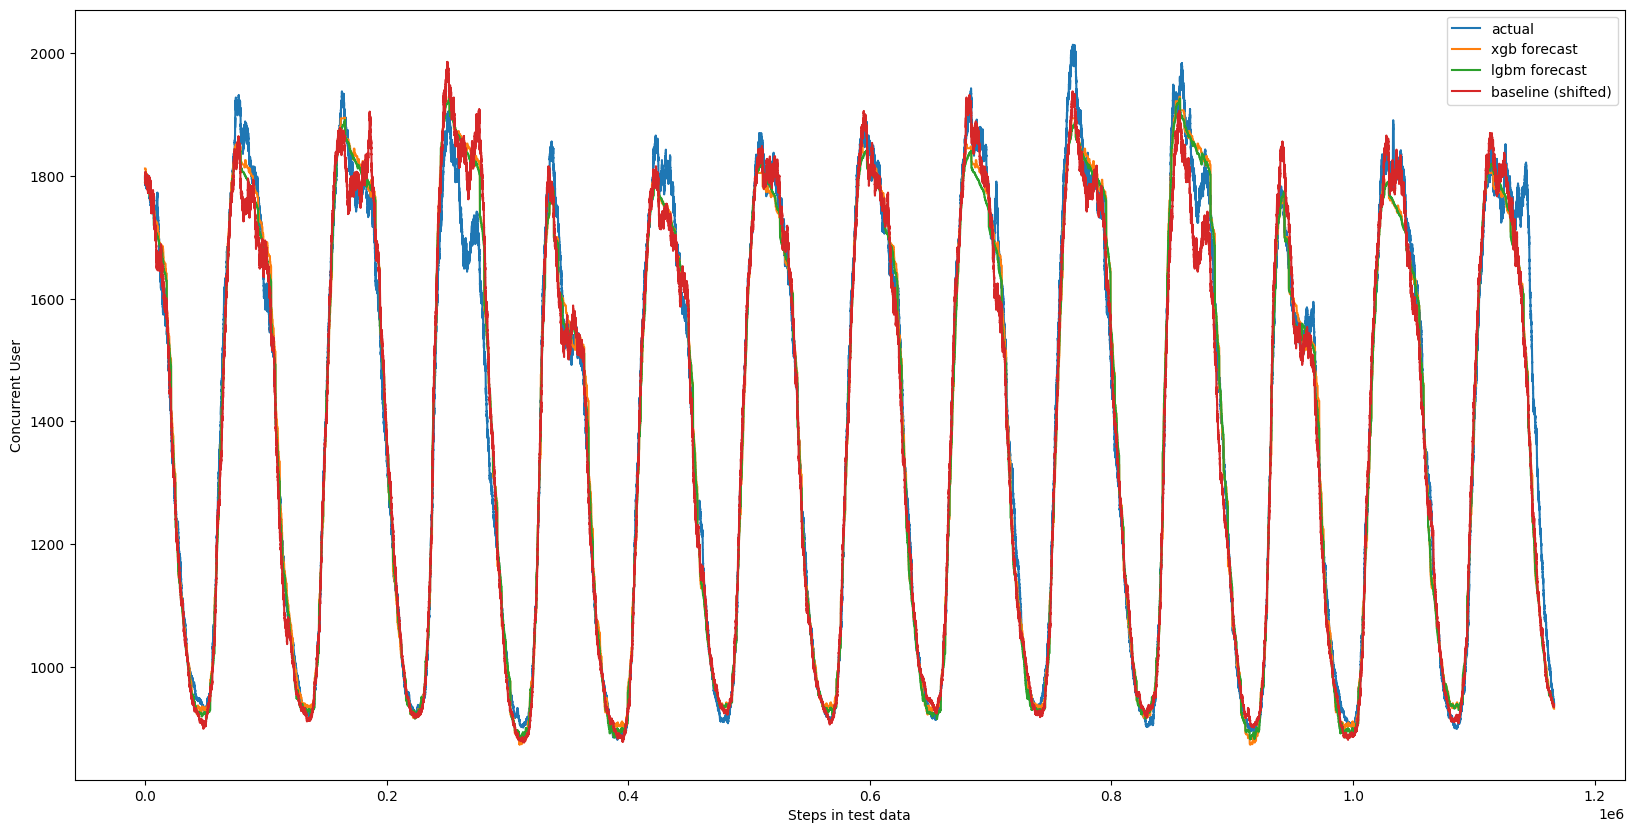

In [ ]:
# Create a graph to compare the XGBoost and LightGBM forecasts to the actual values

# Create a new figure with a specified size
plt.figure(figsize=(20, 10))

# Plot the actual test data values
plt.plot(list(y_test))

# Plot the predicted values from the optimized XGBoost model
plt.plot(list(xgb_pred_opt))

# Plot the predicted values from the optimized LightGBM model
plt.plot(list(lgbm_pred_opt))

# Add a legend to the plot for clarity
plt.legend(['actual', 'xgb forecast', 'lgbm forecast'])

# Label the y-axis
plt.ylabel('Concurrent User')

# Label the x-axis
plt.xlabel('Steps in test data')

# Display the plot
plt.show()


This summary presents the performance metrics of five different models developed to predict concurrent sessions. Each model is evaluated based on Mean Squared Error (MSE), Mean Absolute Error (MAE), R-Squared (R²), and Explained Variance. Below is a detailed comparison of these models:

1. **baseline_model**
   - **Features**: concurrent_sessions_7D
   - **MSE**: 3099.132959
   - **MAE**: 37.412436
   - **R²**: 0.975018
   - **Explained Variance**: 0.975988

2. **XGBoost_default**
   - **Features**: ['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']
   - **MSE**: 3206.561853
   - **MAE**: 38.182828
   - **R²**: 0.974152
   - **Explained Variance**: 0.974425

3. **LightGBM_default**
   - **Features**: ['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']
   - **MSE**: 2816.081302
   - **MAE**: 34.944549
   - **R²**: 0.977300
   - **Explained Variance**: 0.977752

4. **XGBoost_optimized**
   - **Features**: ['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']
   - **MSE**: 2622.032948
   - **MAE**: 34.342699
   - **R²**: 0.978864
   - **Explained Variance**: 0.978941

5. **LightGBM_optimized**
   - **Features**: ['year', 'month', 'week', 'hour', 'minute', 'second', 'day_week', 'day_month', 'daytime']
   - **MSE**: 2656.385965
   - **MAE**: 34.765620
   - **R²**: 0.978587
   - **Explained Variance**: 0.979073

### **Key Observations:**
- **Best Performing Model**: The **XGBoost_optimized** model demonstrated the best performance with the lowest MSE (2622.03) and the highest R² (0.978864), indicating the highest accuracy and best fit to the data.
- **Baseline Comparison**: The baseline model, which uses only the last seven days of concurrent sessions as features, performed well with an MSE of 3099.13 and R² of 0.975018. However, it was outperformed by the optimized models.
- **Impact of Optimization**: Both optimized models (XGBoost and LightGBM) showed significant improvement over their default counterparts. The XGBoost_optimized model had a lower MSE and higher R² compared to the XGBoost_default model. Similarly, the LightGBM_optimized model improved upon the LightGBM_default model.
- **Feature Rich Models**: Models using a broad range of temporal features (year, month, week, hour, minute, second, day of the week, day of the month, and daytime) generally performed better than the baseline model, suggesting that incorporating these features helps in better capturing the patterns in the data.

In conclusion, the XGBoost_optimized model provides the most accurate predictions for concurrent sessions, followed closely by the LightGBM_optimized model. Both these models benefit from the optimization process and the inclusion of a wide array of temporal features.

---
---
---